Name: Ibrahim Odumas Odufowora <br />
Project Name: Classification with MNIST <br />

# Problems Identification:
This project involves the implementation of efficient and effective KNN classifiers on MNIST data set. The MNIST data comprises of digital images of several digits ranging from 0 to 9. Each image is 28 x 28 pixels. Thus, the data set has 10 levels of classes.

These are the needed packages:

In [217]:
from scipy.stats import mode
import numpy as np
from mnist import MNIST
from time import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
plt.rcdefaults()
from IPython.display import display, HTML
from itertools import chain
from sklearn.metrics import confusion_matrix
from pylab import subplot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import pandas as pd
import numpy as np
from plotly.graph_objs import *

Load the dataset, having downloaded it from Yann. The train data set comprises of 60,000 samples and the test data set has 10,000 samples.

In [218]:
mndata = MNIST(os.getcwd() +'\\image')
train_image, train_label = mndata.load_training() #train & train_label
test_image, test_label = mndata.load_testing() #test & test_label

train = np.asarray([np.reshape(x, (784)) for x in train_image]) #change train_image to numpy array #784 means 28 by 28 pixel
train_label = np.asarray(train_label)
test = np.asarray([np.reshape(x, (784)) for x in test_image]) #change test_image to numpy array
test_label = np.asarray(test_label)

The train and test images were reshaped to 784 dimension long, which translate to one feature for each pixel in the image.

### Visualization:
Visualizing a random 28 by 28 image.

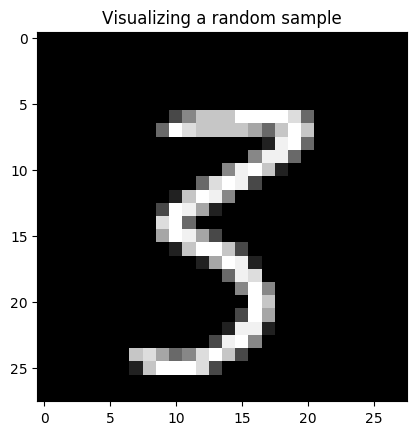

In [147]:
plt.imshow(np.reshape(train[random.randint(1,1000)], [28,28]), cmap='Greys_r'); plt.title('Visualizing a random sample'); plt.show()

### Implementation functions:

In [314]:
def knn_error_per_class(train, train_label, test, test_label, k):
    st_time = time()
    classifier = [[], [], [], [], [], [], [], [], [], []] #10 classes
    error_per_class = []
    count = []
    confusionMatrix = []
    for i, val in enumerate(test_label):
        diff = (train - test[i])
        dist = np.einsum('ij, ij->i', diff, diff)  # quick distance measure
        nearest_lbs = train_label[np.argsort(dist)[:k]]
        major = mode(nearest_lbs)[0][0]
        confusionMatrix.append(major)

        for j in range(len(classifier)):
            if j == val:
                if major == val:
                    classifier[j].append(1)
                else:
                    classifier[j].append(0)
                break

    for c in range(len(classifier)):
        error_per_class.append(1 - np.mean(classifier[c]))
        count.append(len(classifier[c]))

    return [error_per_class, count, classifier, (time()-st_time), confusionMatrix]

def confusionMatrix(actual, predict, isprint=True):
    cfm = pd.DataFrame(confusion_matrix(actual, predict))
    if isprint == True:
        print('Testing Confusion Matrix: Actual vs. Prediction')
        display(cfm)
    return cfm

def error_per_digit(knn_per_err, k):
    tab_error = pd.DataFrame(columns=['digit', 'error per digit in %'])
    tab_error['digit'] = range(len(knn_per_err[0]))
    tab_error['error per digit in %'] = np.round(np.asarray(knn_per_err[0]) * 100, 4)
    display(tab_error)
    unlist_classes = list(chain.from_iterable(knn_per_err[2]))
    overall_error = round(1 - np.mean(unlist_classes), 4)
    print('\nThe overall testing error is {}% for k = {}.'.format(round(overall_error*100, 4), k))

def my_knn_loocv(train_all, train_label_all, k_all):
    st_time = time()
    dt_classifier = pd.DataFrame(index=range(len(train_label_all)), columns=range(len(k_all)))
    for j, res in enumerate(train_label_all):
        test = train_all[j]
        test_label = train_label_all[j]
        train = np.delete(train_all, j, 0)
        train_label = np.delete(train_label_all, j)

        diff = (train - test)
        dist = np.einsum('ij, ij->i', diff, diff)  # quick distance measure
        for k, k_val in enumerate(k_all):
            nearest_lbs = train_label[np.argsort(dist)[:k_val]]
            major = mode(nearest_lbs)[0][0]
            if major == test_label:
                dt_classifier.iloc[j][k] = 1
            else:
                dt_classifier.iloc[j][k] = 0

    dt_error = 1 - dt_classifier.mean(axis=0)
    return [dt_error, dt_classifier, (time()-st_time)]

def loocv_error_per_k(knn_loocv, k_list):
    k_error = np.round(np.asarray(knn_loocv[0]) * 100, 4)
    best_k = list(np.argsort(k_error)[:1] + 1).pop()
    err_best_k = list(k_error[np.argsort(k_error)[:1]]).pop()
    plt.plot(k_list, k_error, '-gD', color='black')
    ax = subplot(111)
    ax.set_xticks(np.arange(0, 21, 1))
    plt.ylabel('% Error')
    plt.xlabel('K')
    plt.title('Plot of K vs. leave-one-out error')
    plt.show()
    print('The best value of K is {} with an error of {}%'.format(best_k, err_best_k))
    print('\nK = {} will be used for the testing set:'.format(best_k))
    return [best_k, err_best_k]

def knn_loocv_method(train, train_label, test, test_label, k_list=range(1, 21)):
    knn_loocv = my_knn_loocv(train_all=train, train_label_all=train_label, k_all=k_list)
    loocv = loocv_error_per_k(knn_loocv, k_list)
    knn_per_err = knn_error_per_class(train=train, train_label=train_label, test=test, test_label=test_label, k=loocv[0])
    confusionMatrix(test_label, knn_per_err[4], isprint=True)
    error_per_digit(knn_per_err, loocv[0])
    return knn_per_err
    
def my_PCA(jupyter=True, scale_norm=False, data=train): #PCA Basis Function
    #There is no need to center and scale because the original data has been centered and scaled
    if scale_norm == True:
        data = np.asarray(data)
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        data = (data - mean) / std

    covariance_matrix = np.cov(data.T)  # Covariance Matrix of the normalized data
    # eigenValues and eigenvectors of the covariance Matrix
    # the eigenvectors only define the directions of the new axis
    eigenvals, eigenvecs = np.linalg.eig(covariance_matrix)
    eigenvals = eigenvals.real
    eigenvecs = eigenvecs.real

    #computing singular value decomposion
    #This was done to check if singular value decomposition is similar results as the eigenvalues and eigenvectors
    U, s, V = np.linalg.svd(covariance_matrix, full_matrices=True)

    # confirming that the unit length of each of the eigenvector is 1
    eigenvecs_lens = []
    for i in range(len(eigenvecs)):
        eigenvecs_lens.append(np.linalg.norm(eigenvecs[i]))

    sum_eigenval = sum(eigenvals)
    var_expl = [(i / sum_eigenval) * 100 for i in sorted(eigenvals, reverse=True)] #Variance Explained
    cum_var_exp = np.cumsum(var_expl) #Cummulative varinace explained
    leng = len(eigenvals) + 1
    #bar_data = Bar(x=['PC %s' % i for i in range(1, leng)], y=var_expl, showlegend=False)
    scatter_data = Scatter(x=['PC %s' % i for i in range(1, leng)], y=cum_var_exp, name='cumulative explained variance')
    #data = Data([bar_data, scatter_data])
    data_plt = Data([scatter_data])
    layout = Layout(yaxis=YAxis(title='explained variance in percent'), title='Cumulative Explained variance by different principal components 1 - 784')
    fig = Figure(data=data_plt, layout=layout)
    if jupyter == True:
        iplot(fig)
    else:
        plot(fig)

    return [eigenvecs, eigenvals, eigenvecs_lens, U]

def pca_transform_results(error, var, comp, best_K, querytim):
    tab = pd.DataFrame(columns=['% variance Explain', 'no of components', 'best K used','test error in %', 'query time (ms)'])
    tab['% variance Explain'] =  var
    tab['no of components'] =  comp
    tab['best K used'] =  best_K
    tab['test error in %'] =  error
    tab['query time (ms)'] =  querytim
    display(tab)
    
    plt.subplots(figsize=(20, 10))
    plt.plot(comp, error, label="test error rate (%)") 
    plt.plot(comp, querytim, label="query time (ms)")
    plt.plot(comp, best_K, label="best k used")
    plt.xlabel('number of components used')
    plt.xticks(comp, comp)
    plt.legend()
    plt.title('Plot of PCA components used vs. Test Error, Best value of k, and Query Time')
    plt.show()

# Method - Dimension Reduction (PCA): 
I implemented a function called my_PCA, it returns the corresponding basis vectors, it also plots cumulative explained variance by the different component. The total components is 784. 

Reduce data from n-dimension to m-dimension:

Transformation using my function (my_PCA) involves the use of the train set to derive basis vectors of 784 components. The steps are outlined below:
1. The original images have been centered and scaled, thus there is no need to apply centering and scaling.
2. Obtain the covariance matrix of the data

    $$\sum = \frac{1}{N}\sum_{i=1}^{n}\left ( X^{\left ( i \right )} \right )^{T}\left ( X^{\left ( i \right )} \right )$$
    
    This will result in a n x n matrix <br>
    
    
3. Derive the eigenvectors and eigenvalues from the covariance matrix 
4. Confirm that the all the eigenvectors has a unit length of 1
5. Plot cumulative variance explained by using sorted the eigenvalues in descending order
6. Having gotten the eigenvectors, then transform the original datasets via basis vectors to obtain a reduced dimension depending on the desired explained variance.

In [237]:
basis_vecs = my_PCA()

The plot above is the cumulative explained variance by principal components 1 - 784. The x-label is the principal components 1 - 784. Kindly mouse-over the plot to explore the PC and the cumulative explained variance.

##### LOOCV and testing analysis were performed using 99%, 95%, 90%, 85%, and 75% variance explained, and their results are presented below.

In [249]:
train_PCA = np.dot(train, basis_vecs[0][:,0:331])
train_PCA.shape

(60000, 331)

In [250]:
test_PCA = np.dot(test, basis_vecs[0][:,0:331])
test_PCA.shape

(10000, 331)

### LOOCV and testing analysis having reduced the dimension of the dataset to 331 (99% Variance Explained):

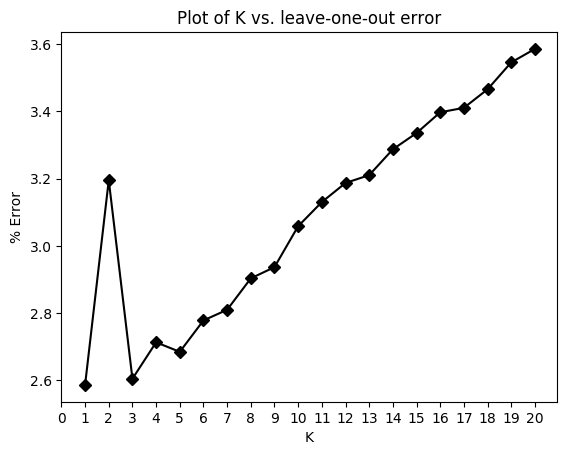

The best value of K is 1 with an error of 2.5867%

K = 1 will be used for the testing set:
Testing Confusion Matrix: Actual vs. Prediction


,0,1,2,3,4,5,6,7,8,9
0,973,1,1,0,0,1,3,1,0,0
1,0,1129,3,0,1,1,1,0,0,0
2,7,6,994,5,1,0,2,14,3,0
3,1,1,2,968,1,19,0,7,7,4
4,0,7,0,0,941,0,4,5,2,23
5,1,1,0,11,2,861,6,1,5,4
6,4,2,0,0,3,5,944,0,0,0
7,0,15,6,2,5,0,0,990,0,10
8,5,1,3,14,5,12,3,4,922,5
9,2,5,1,6,10,5,1,12,1,966


,digit,error per digit in %
0,0,0.7143
1,1,0.5286
2,2,3.6822
3,3,4.1584
4,4,4.1752
5,5,3.4753
6,6,1.4614
7,7,3.6965
8,8,5.3388
9,9,4.2616



The overall testing error is 3.12% for k = 1.


In [251]:
result_pca = knn_loocv_method(train_PCA, train_label, test_PCA, test_label, k_list=range(1, 21))

In [252]:
train_PCA_low = np.dot(train, basis_vecs[0][:,0:155])
train_PCA_low.shape

(60000, 155)

In [253]:
test_PCA_low = np.dot(test, basis_vecs[0][:,0:155])
test_PCA_low.shape

(10000, 155)

### LOOCV and testing analysis having reduced the dimension of the dataset to 155  (95% Variance Explained): 

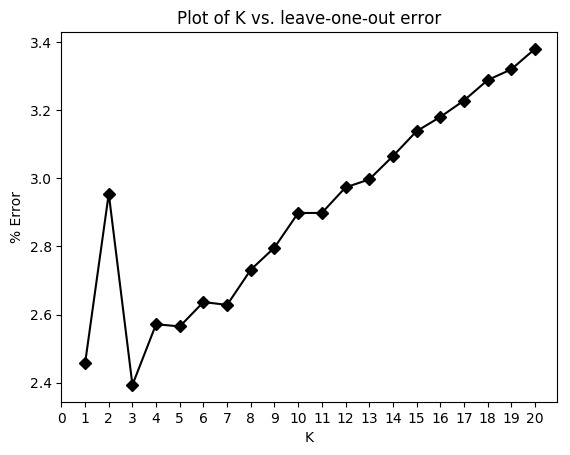

The best value of K is 3 with an error of 2.3933%

K = 3 will be used for the testing set:
Testing Confusion Matrix: Actual vs. Prediction


,0,1,2,3,4,5,6,7,8,9
0,974,1,1,0,0,1,2,1,0,0
1,0,1132,2,0,0,0,1,0,0,0
2,9,8,997,2,1,0,0,14,1,0
3,1,2,3,978,1,12,0,7,3,3
4,1,5,0,0,952,0,4,2,0,18
5,6,1,0,11,1,860,5,1,3,4
6,5,3,0,0,2,3,945,0,0,0
7,0,17,5,0,1,0,0,997,0,8
8,7,2,4,16,7,9,3,3,920,3
9,4,4,2,9,10,2,1,9,1,967


,digit,error per digit in %
0,0,0.6122
1,1,0.2643
2,2,3.3915
3,3,3.1683
4,4,3.0550
5,5,3.5874
6,6,1.3570
7,7,3.0156
8,8,5.5441
9,9,4.1625



The overall testing error is 2.78% for k = 3.


In [254]:
result_pca_low = knn_loocv_method(train_PCA_low, train_label, test_PCA_low, test_label, k_list=range(1, 21))

In [255]:
train_PCA_low_1 = np.dot(train, basis_vecs[0][:,0:87])
train_PCA_low_1.shape

(60000, 87)

In [256]:
test_PCA_low_1 = np.dot(test, basis_vecs[0][:,0:87])
test_PCA_low_1.shape

(10000, 87)

### LOOCV and testing analysis having reduced the dimension of the dataset to 87  (90% Variance Explained): 

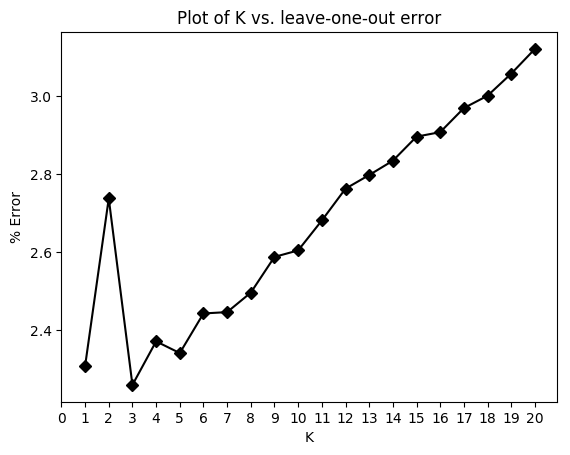

The best value of K is 3 with an error of 2.26%

K = 3 will be used for the testing set:
Testing Confusion Matrix: Actual vs. Prediction


,0,1,2,3,4,5,6,7,8,9
0,974,1,1,0,0,1,2,1,0,0
1,0,1131,3,0,0,0,1,0,0,0
2,7,4,1002,2,1,0,0,14,2,0
3,0,1,5,977,1,11,0,7,5,3
4,2,6,0,0,952,0,4,2,0,16
5,3,1,0,9,2,866,4,1,2,4
6,5,3,0,0,2,3,945,0,0,0
7,0,16,6,0,2,0,0,998,0,6
8,6,1,3,15,6,13,3,3,921,3
9,5,5,2,9,9,3,1,3,3,969


,digit,error per digit in %
0,0,0.6122
1,1,0.3524
2,2,2.9070
3,3,3.2673
4,4,3.0550
5,5,2.9148
6,6,1.3570
7,7,2.9183
8,8,5.4415
9,9,3.9643



The overall testing error is 2.65% for k = 3.


In [257]:
result_pca_low_1 = knn_loocv_method(train_PCA_low_1, train_label, test_PCA_low_1, test_label, k_list=range(1, 21))

In [258]:
train_PCA_low_2 = np.dot(train, basis_vecs[0][:,0:59])
train_PCA_low_2.shape

(60000, 59)

In [259]:
test_PCA_low_2 = np.dot(test, basis_vecs[0][:,0:59])
test_PCA_low_2.shape

(10000, 59)

### LOOCV and testing analysis having reduced the dimension of the dataset to 59  (85% Variance Explained): 

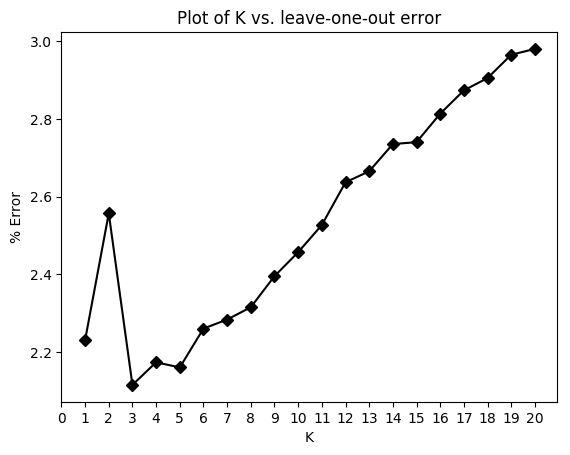

The best value of K is 3 with an error of 2.115%

K = 3 will be used for the testing set:
Testing Confusion Matrix: Actual vs. Prediction


,0,1,2,3,4,5,6,7,8,9
0,974,1,1,0,0,1,2,1,0,0
1,0,1130,3,0,0,0,1,0,0,1
2,5,4,1007,1,1,0,1,11,2,0
3,0,0,3,977,1,11,0,9,8,1
4,1,1,0,0,959,0,4,1,0,16
5,4,1,0,10,2,863,6,1,2,3
6,5,3,0,0,2,3,945,0,0,0
7,0,14,7,0,2,0,0,999,0,6
8,5,0,3,17,7,7,3,3,925,4
9,6,3,2,7,8,3,1,3,3,973


,digit,error per digit in %
0,0,0.6122
1,1,0.4405
2,2,2.4225
3,3,3.2673
4,4,2.3422
5,5,3.2511
6,6,1.3570
7,7,2.8210
8,8,5.0308
9,9,3.5679



The overall testing error is 2.48% for k = 3.


In [260]:
result_pca_low_2 = knn_loocv_method(train_PCA_low_2, train_label, test_PCA_low_2, test_label, k_list=range(1, 21))

### LOOCV and testing analysis having reduced the dimension of the dataset to 33  (75% Variance Explained): 

In [261]:
train_PCA_low_3 = np.dot(train, basis_vecs[0][:,0:33])
train_PCA_low_3.shape

(60000, 33)

In [262]:
test_PCA_low_3 = np.dot(test, basis_vecs[0][:,0:33])
test_PCA_low_3.shape

(10000, 33)

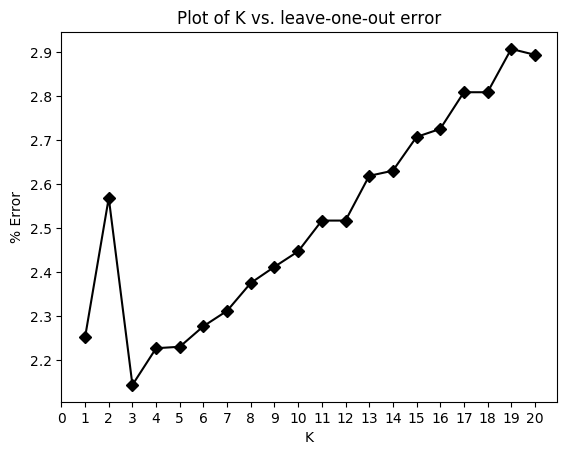

The best value of K is 3 with an error of 2.1433%

K = 3 will be used for the testing set:
Testing Confusion Matrix: Actual vs. Prediction


,0,1,2,3,4,5,6,7,8,9
0,974,1,1,0,0,1,2,1,0,0
1,0,1131,3,0,0,0,0,0,0,1
2,5,2,1009,1,1,0,3,9,2,0
3,0,0,5,974,0,14,0,6,7,4
4,1,0,0,0,951,1,2,2,1,24
5,3,1,0,11,2,864,5,1,2,3
6,3,4,0,0,3,2,945,0,1,0
7,0,14,11,0,3,0,0,992,0,8
8,3,0,4,14,3,5,3,3,936,3
9,6,4,1,7,11,3,1,4,5,967


,digit,error per digit in %
0,0,0.6122
1,1,0.3524
2,2,2.2287
3,3,3.5644
4,4,3.1568
5,5,3.1390
6,6,1.3570
7,7,3.5019
8,8,3.9014
9,9,4.1625



The overall testing error is 2.57% for k = 3.


In [263]:
result_pca_low_3 = knn_loocv_method(train_PCA_low_3, train_label, test_PCA_low_3, test_label, k_list=range(1, 21))

,% variance Explain,no of components,best K used,test error in %,query time (ms)
0,99,331,1,3.12,123.0881
1,95,155,3,2.78,50.6090
2,90,87,3,2.65,36.7794
3,85,59,3,2.48,28.5892
4,75,33,3,2.57,16.4162


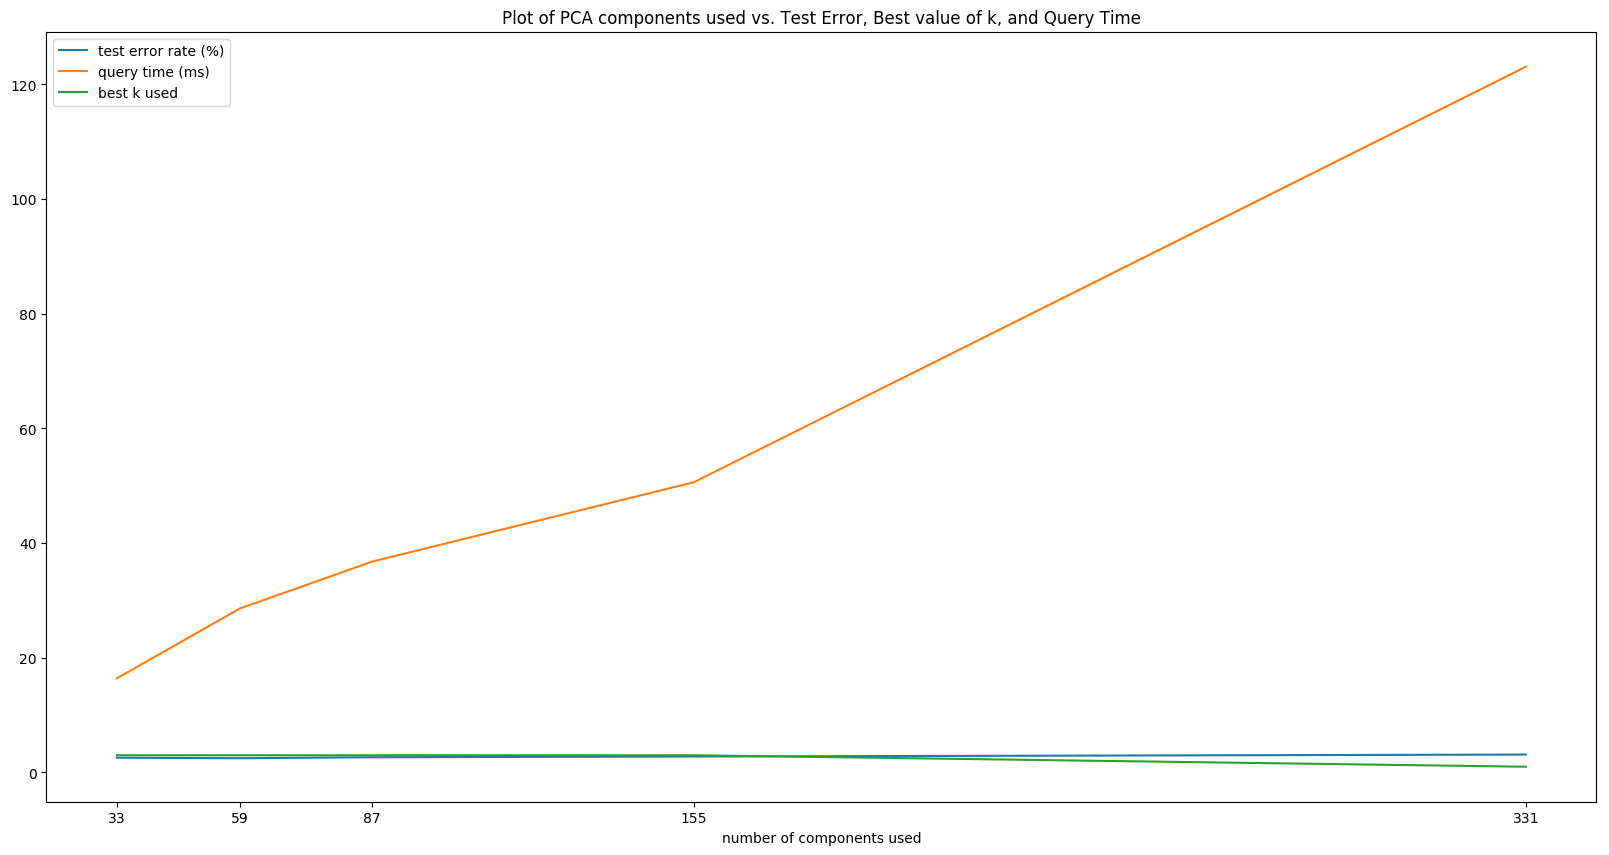

In [312]:
querytimes_ = [round(result_pca[3]/10, 4), round(result_pca_low[3]/10, 4), round(result_pca_low_1[3]/10, 4), round(result_pca_low_2[3]/10, 4), round(result_pca_low_3[3]/10, 4)]
var_exp_ = [99, 95, 90, 85, 75]
components_ = [331, 155, 87, 59, 33]
err_ = [3.12, 2.78, 2.65, 2.48, 2.57]
best_k_ = [1, 3, 3, 3, 3]
pca_transform_results(err_, var_exp_, components_, best_k_, querytimes_)

The immediate table and plot above summarise the result of the PCA transformations by 33, 59, 87, 155 and 331 components which correspond to 75, 85 90, 95 and 99 percent variance explained.

The best value of K is 3 except in the transformation with 331 components where K is 1, also the best test error rate is at transformation with 59 components. Transformation with 331 components performs poorly in terms of query time and error rate. 

Generally, transformation with 59 component(85% variance explained) is efficient in terms of low error rate and low query time, it is by far the best in this study. 